## Answering Business Questions Using SQL

In this project, I will be analysing tables in the [Chinook database](https://github.com/lerocha/chinook-database) that contains information from a Music Shop. Throughout the project, I will aim to answer different business questions by using: 
- the SQLite library for reading from the DB 
- pandas for handling data 
- and Matplotlib for visualisation.

### Importing libraries, creating helper functions and reading the database

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db= 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level= None
        conn.execute(c)
        
def show_tables():
    q= '''
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ("table","view")
    '''
    return run_query(q)

show_tables()  

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
# viewing some data in one of the tables
select_data= '''
SELECT * 
FROM invoice
'''
run_query(select_data).head()

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
1,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90
2,3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
3,4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
4,5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83


### What kind of albums should we be selling?

For this business question, we will look at past sales of albums based on genre.


In [3]:
# this query will return results of each genre, with the number of tracks sold
# in absolute numbers and in percentages.
albums_to_purchase= '''
      WITH subquery AS 
               (SELECT * 
                  FROM customer c 
            INNER JOIN invoice i 
                    ON i.customer_id = c.customer_id 
            INNER JOIN invoice_line il 
                    ON il.invoice_id = i.invoice_id) 
    SELECT g.NAME genre, 
           Count (s.quantity) tracks_sold, 
           (Cast(Count(s.quantity) AS FLOAT))/ 
                            (SELECT Count(*) 
                               FROM subquery) percent_tracks_sold 
      FROM subquery s 
INNER JOIN track t 
        ON t.track_id = s.track_id 
INNER JOIN genre g 
        ON g.genre_id = t.genre_id 
  GROUP BY 1 
  ORDER BY 2 DESC limit 10
    '''

run_query(albums_to_purchase)
    

,genre,tracks_sold,percent_tracks_sold
0,Rock,2635,0.553921
1,Metal,619,0.130124
2,Alternative & Punk,492,0.103427
3,Latin,167,0.035106
4,R&B/Soul,159,0.033424
5,Blues,124,0.026067
6,Jazz,121,0.025436
7,Alternative,117,0.024595
8,Easy Listening,74,0.015556
9,Pop,63,0.013244


Next, I will plot some data from the result set in a bar plot.

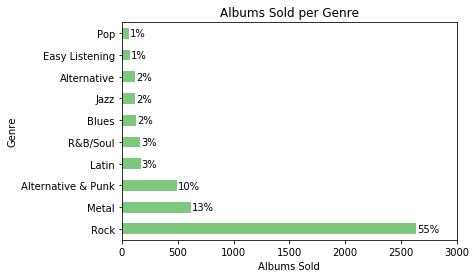

In [4]:
genre_sales = run_query(albums_to_purchase)
genre_sales.set_index("genre", inplace= True, drop= True)

genre_sales["tracks_sold"].plot.barh(
    title= "Albums Sold per Genre",
    xlim= (0, 3000),
    colormap=plt.cm.Accent)

plt.ylabel('Genre')
plt.xlabel('Albums Sold')

for i, label in enumerate (list(genre_sales.index)):
    score = genre_sales.loc[label, "tracks_sold"]
    label= (genre_sales.loc[label, "percent_tracks_sold"]*100
           ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))
plt.show()

Based on the sales of tracks across different genres, we should purchase Rock genre albums since they account for 55% of sales.

### How is employee performance?
Here, we want to assess how our employees have performed in terms of sales generated.

In [5]:
employee_performance= '''
     WITH subquery AS 
              (SELECT * 
                 FROM customer c 
           INNER JOIN invoice i 
                   ON i.customer_id = c.customer_id) 
   SELECT e.employee_id, 
          e.hire_date, 
          Sum(s.total) total_sales 
     FROM employee e 
LEFT JOIN subquery s 
       ON e.employee_id = s.support_rep_id 
    WHERE e.title = "Sales Support Agent" 
    GROUP BY 1 
    ORDER BY 2 DESC 

   
 '''
run_query(employee_performance)

,employee_id,hire_date,total_sales
0,5,2017-10-17 00:00:00,1393.92
1,4,2017-05-03 00:00:00,1584.00
2,3,2017-04-01 00:00:00,1731.51


I will plot some data from the result set in a bar plot.

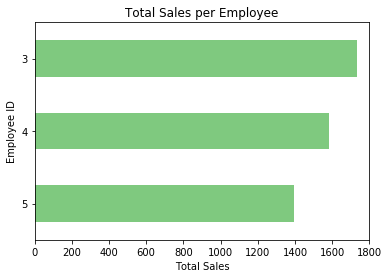

In [6]:
employee_perf = run_query(employee_performance)
employee_perf.set_index("employee_id", inplace= True, drop= True)

employee_perf["total_sales"].plot.barh(
    title= "Total Sales per Employee",
    xlim= (0, 1800),
    colormap=plt.cm.Accent)

plt.ylabel('Employee ID')
plt.xlabel('Total Sales')
plt.show()

The employees were all hired within 6 months of one another. The longest standing employee is also the top selling employee with more sales than the other two newer ones, which is as expected as they had more time to produce more sales. 

There is a ~350 sales difference between the top employee and the bottom employee, which is a difference of 24%.

### How do sales vary between countries?
We can use the results of this question to see where there are opportunities.

In [7]:
a= ''' DROP VIEW IF EXISTS country_customer_sales'''
run_command(a)

#Creating table view to do calculations before grouping and sorting in next cell
c= '''
CREATE VIEW country_customer_sales 
         AS 
     SELECT c.country, 
            Count (DISTINCT c.customer_id)  total_country_customer, 
            SUM (i.total)                   total_country_sales, 
            SUM (i.total) / COUNT(DISTINCT c.customer_id) 
                                            average_value_sale_per_customer, 
            SUM (i.total) / COUNT(i.invoice_id) 
                                            average_order_value 
       FROM customer c 
 INNER JOIN invoice i 
         ON i.customer_id = c.customer_id 
   GROUP BY 1 
   ORDER BY 3 DESC; 

'''
run_command(c)

In [8]:
#Grouping and sorting table view created in previous cell
q = '''
  SELECT country, 
         SUM(total_country_customer) total_country_customer, 
         SUM(total_country_sales)    total_country_sales, 
         SUM(average_value_sale_per_customer) / Count(total_country_customer) 
                                     average_value_sale_per_customer, 
         SUM(average_order_value) / COUNT(total_country_customer) 
                                     average_order_value 
    FROM (SELECT CASE 
                 WHEN ccs.total_country_customer = 1 THEN "Other" 
                 ELSE ccs.country 
               END AS country, 
                 CASE 
                 WHEN ccs.total_country_customer = 1 THEN 1 
                 ELSE 0 
               END AS sort, 
                 ccs.total_country_customer, 
                 ccs.total_country_sales, 
                 ccs.average_value_sale_per_customer, 
                 ccs.average_order_value 
            FROM country_customer_sales ccs)  
GROUP BY country 
ORDER BY sort ASC, 
         total_country_sales DESC 
'''

run_query(q)

,country,total_country_customer,total_country_sales,average_value_sale_per_customer,average_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.445071


This result set has aggregated the data to give per country metrics of:
- total customers
- total sales (USD)
- average value of sales per customer (USD)
- average order value (USD)

There is also an "Other" group of 15 other countries. They have been classed as "Other" because we only have 1 customer per country in this group, and each have less sales value than than India (has 2 customers).

In [9]:
country_sale = run_query(q)

#### Visualising Sales per Country

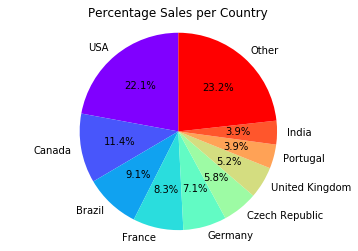

In [10]:
x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

labels = country_sale['country']
values = country_sale['total_country_sales']

plt.pie(values, labels=labels, autopct='%1.1f%%', 
       startangle=90, colors=colors )
plt.title('Percentage Sales per Country')

plt.axis("equal")
plt.show()

From this pie chart, we can see that the USA account for 22.1% of sales. 

We can also see there are 8 other countries which account for the majority of the rest of sale. 

Also, the "Other" group of 15 other countries (with 1 customer each) account for 23.2% of sales. 

#### Visualising Sales and Customers per Country

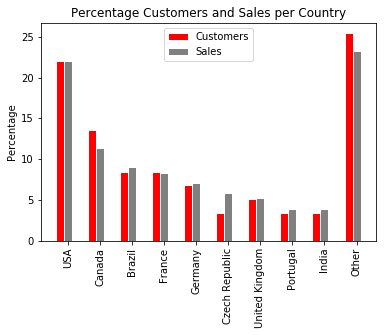

In [11]:
customer = country_sale['total_country_customer']
sales = country_sale['total_country_sales']

percent_customer = (customer/customer.sum())*100
percent_sales = (sales/sales.sum())*100

barWidth = 0.25

r1 = np.arange(len(percent_customer))
r2 = [x + barWidth for x in r1]

plt.bar(r1, percent_customer, color='red', width=barWidth, 
        edgecolor='white', label='Customers')
plt.bar(r2, percent_sales, color='grey', width=barWidth, 
        edgecolor='white', label='Sales')

plt.xticks([r + barWidth for r in range(10)], 
           country_sale['country'], rotation=90)
plt.title('Percentage Customers and Sales per Country')

plt.ylabel('Percentage')

plt.legend()
plt.show()


This dual bar plot shows the percentage of total customers and total sales each country accounts for.

The grey bar plots are showing the same sales % values as previously seen in the pie chart before. 

But by also plotting the red bar plot for customers, we can see the relative value of sales given the size of the countries customer base. 

Previously, we already saw that the USA produced the most sales, and now we can see it also holds the most customers so this might've been expected.

More interestingly, we can see the Czech Republic has the highest sales to customer ratio, with ~3% of customer producing ~6% of sales, which is a 2:1 sales to customer ratio, whereas for USA this ratio is 1:1.

#### Visualising Average Country Order Value vs Overall Mean

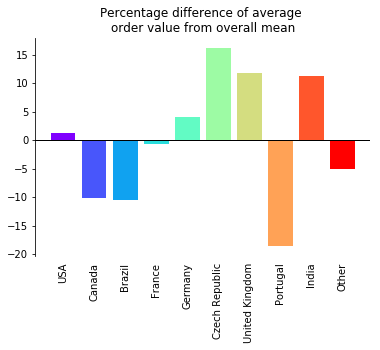

In [12]:
#plots the percentage difference of the average order value 
#from mean value

country = country_sale['country']
value_order = country_sale["average_order_value"]

difference_from_mean = value_order * (100 / value_order.mean()) -100

ax = plt.subplot(111)

plt.bar(x=range(10), height=difference_from_mean, color=colors)
plt.xticks([r  for r in range(10)], 
           country_sale['country'], rotation=90)
plt.tick_params(axis='x', which='both', bottom=False, top=False, 
                labelbottom=True)
plt.axhline(y=0, color='black', linewidth=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.title('Percentage difference of average \norder value from overall mean')
plt.show()

This bar plot shows the difference in average order value from the overall mean per country.

We can see there are 3 countries where this difference is quite significantly high: Czech Republic, United Kingdom and India.

This helps us to understand that customers in these countries have a higher tendency to place higher value orders than customer in other countries e.g Portugal, Canada, Brazil where customers might place lower value orders.

This plot does not account for the volume of orders (i.e how many) customers from each country place. 

#### Visualising Customer Life Time Value

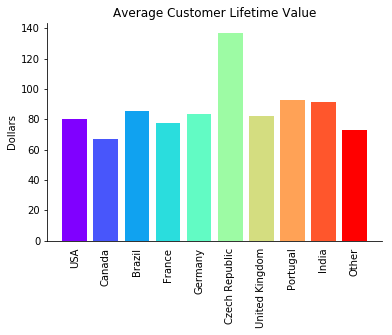

In [13]:
#shows total value customers have spent per country

customer_value = country_sale['average_value_sale_per_customer']

ax = plt.subplot(111)

plt.bar(x=range(10), height=customer_value, color=colors)
plt.xticks([r  for r in range(10)], 
           country_sale['country'], rotation=90)
plt.tick_params(axis='x', which='both', bottom=False, top=False, 
                labelbottom=True)
plt.axhline(y=0, color='black', linewidth=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.ylabel('Dollars')
plt.title('Average Customer Lifetime Value')
plt.show()


This plot shows the average customer lifetime value (i.e average total sales per customer) per country.

We can see than most countries, on average customers spend between ~70USD and ~90USD.

The Czech Republic stands out as significantly higher than the rest, with an value of ~135USD.

#### Where are the opportunities?

Based on these plots, there may be opportunity in:
* Czech Rebulic 
    - ratio of value of sales to number of customers is the highest
    - and on average, customers are making higher value orders compared to other countries. 

* United Kingdom
* India 
    - customers in these countries also have a higher average order spend compared to other countries, 
    - and also have a favourable sales to customer ratio.

However, the sample size is relatively low (these 3 countries make up less than 25% of the overall sales). So we should be cautious in investing a lot of money in marketing for now. 

Rather, we could suggest running smaller campaigns and analyzing data from the new customers to make sure that these trends still hold, and then decide if it is worth further investment.